In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, random

import sklearn
from sklearn import ensemble, model_selection, preprocessing, tree, linear_model, neighbors
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix

### I'm using  plot_confusion_matrix  function taken from kernel found on Kaggle
####  Credit to [George Fisher](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/notebook) who has licensed it under an [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0)  open source license

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### A function for pickling the classifiers (not necessary)

In [3]:
def pickle_classifier(filepath, classifier):
    """Function to automate the pickling of a classifier
    """
    with open(filepath, 'wb') as f:
        pickle.dump(classifier, f)

def load_pickled_classifier(filepath):
    """Function to load a pickled classifier
    """
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [4]:
df = pd.read_json('..\\data\\cleaned_df_numerical_columns_only.json')
df = df.astype(float)
# moving converted to last column (was thinking of using random.shuffle)
df_score = df['score']
df = df.drop(['score'], axis=1)
df['score'] = df_score

redundant_columns = [
    'score_normalized',
    'days_since_signup_normalized'
]
df.drop(redundant_columns, axis=1, inplace=True)

In [5]:
df.head()

,days_since_signup,completed_form,visited_pricing,registered_for_webinar,attended_webinar,converted,is_manager,acquisition_channel_cold_call,acquisition_channel_cold_email,acquisition_channel_organic_search,...,is_sales,is_marketing,is_other,is_web_ind,is_financials_ind,is_furniture_ind,is_transportation_ind,is_manufacturing_ind,is_scandesign_ind,score
0,18.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,151.000000
1,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,141.358438
10,27.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,129.741042
100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,86.848001
1000,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.539353


### Random Forest

In [6]:
X = df.drop(columns=['score'])
X = preprocessing.scale(X)
y = df.score

In [8]:
# for i in range(1, 11):
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

#     n_trees = 500
#     clf = ensemble.RandomForestClassifier(max_features='auto', n_estimators=n_trees, random_state=None, n_jobs=-1)
#     clf.fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)
#     print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
# pickle_classifier('..\\classifiers\\random_forest_score.pickle', clf)

In [9]:
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# cm

In [10]:
# plot_confusion_matrix(cm           = cm, 
#                       normalize    = False,
#                       target_names = ['No', 'Yes'],
#                       title        = "Confusion Matrix -- Random Forest")

In [11]:
# print(clf.decision_path(X))
# print(clf.feature_importances_)

##### ROC Curve

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
# roc_viz = ROCAUC(clf)
# roc_viz.score(X_test,y_test)

# roc_viz.poof()

## Logistic Regression

In [12]:
X = df.drop(columns=['score'])
X = preprocessing.scale(X)
y = df.score

In [14]:
# for i in range(1, 11):
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

#     clf = linear_model.LogisticRegression(random_state=None, solver='lbfgs', n_jobs=-1)
#     clf.fit(X_train, y_train)
#     accuracy = clf.score(X_test, y_test)
#     print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
# pickle_classifier('..\\classifiers\\logistic_regression_score.pickle', clf)

In [15]:
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# cm

In [16]:
# print(clf.decision_function(X))
# print(clf.decision_function(X).mean())
# pd.DataFrame(clf.decision_function(X)>0).describe()

In [17]:
# plot_confusion_matrix(cm           = cm, 
#                       normalize    = False,
#                       target_names = ['No', 'Yes'],
#                       title        = "Confusion Matrix -- Logistic Regression")

## Linear Regression

In [18]:
X = df.drop(columns=['score'])
X = preprocessing.scale(X)
y = df.score

In [19]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = linear_model.LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\linear_regression_score.pickle', clf)

Test 1 Accuracy:	0.5854110781446422
Test 2 Accuracy:	0.5875150507022473
Test 3 Accuracy:	0.5789705829601716
Test 4 Accuracy:	0.590978929794437
Test 5 Accuracy:	0.5862141017866584
Test 6 Accuracy:	0.5837419042911598
Test 7 Accuracy:	0.5990813579460126
Test 8 Accuracy:	0.5862172311379583
Test 9 Accuracy:	0.5964103373791259
Test 10 Accuracy:	0.5896656044189892


In [29]:
y_pred = clf.predict(X_test)
# y_pred = [0 if c <= 150 else 1 for c in y_pred]
y_pred
# cm = confusion_matrix(y_test, y_pred)
# cm

array([238.42177235, 109.11708485, 104.64833485, ..., 105.2459911 ,
        73.61854969, 110.38270985])

In [28]:
# plot_confusion_matrix(cm           = cm, 
#                       normalize    = False,
#                       target_names = ['No', 'Yes'],
#                       title        = "Confusion Matrix -- Linear Regression")

## K Nearest Neighbor (KNN)

In [30]:
X = df.drop(columns=['score'])
X = preprocessing.scale(X)
y = df.score

#### KNN Regressor

In [47]:
for i in range(1, 2):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_regressor_score.pickle', clf)

Test 1 Accuracy:	0.5400275967791051


In [48]:
y_pred = clf.predict(X_test)
# y_pred = [0 if c <= 0.5 else 1 for c in y_pred]
# cm = confusion_matrix(y_test, y_pred)
# cm

In [60]:
y_pred

array([113.29298601, 137.00932838,  83.36084886, ...,  97.53565946,
        71.84512771, 126.9913558 ])

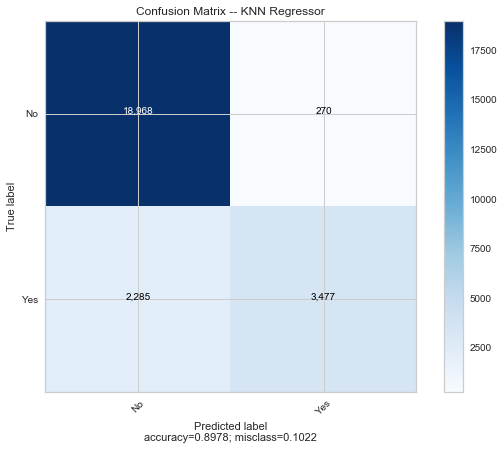

In [30]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Regressor")

#### KNN Classifier

In [31]:
for i in range(1, 11):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.25, random_state=None)

    clf = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print('Test {0} Accuracy:\t{1}'.format(i, accuracy))
    
pickle_classifier('..\\classifiers\\knn_classifier.pickle', clf)

Test 1 Accuracy:	0.89704
Test 2 Accuracy:	0.89724
Test 3 Accuracy:	0.89824
Test 4 Accuracy:	0.8968
Test 5 Accuracy:	0.89664
Test 6 Accuracy:	0.89904
Test 7 Accuracy:	0.89796
Test 8 Accuracy:	0.89796
Test 9 Accuracy:	0.8974
Test 10 Accuracy:	0.89612


In [32]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[18998,   337],
       [ 2260,  3405]], dtype=int64)

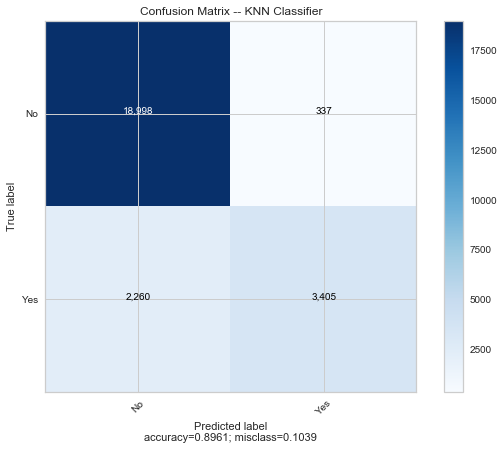

In [33]:
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['No', 'Yes'],
                      title        = "Confusion Matrix -- KNN Classifier")